# Entity Resolution project @ Wavestone
## Entity Matching

> *Datasets information from [here](https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html)*

> **Tristan PERROT**


## Import libraries

In [10]:
import os

while 'model' not in os.listdir():
    os.chdir('..')

In [11]:
import re
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from model.utils import load_data
import src.cross_encoder.result_sberts as result_sberts
import src.import_data as import_data
import re
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from model.utils import load_data
import src.bert.result_berts as result_berts
import src.import_data as import_data
import re
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from model.utils import load_data
from model.Blocking import get_blocking_metrics, merge_true_matches
import src.blocking.result_blocking as result_blocking
import src.import_data as import_data
import re
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from model.utils import load_data
import src.zero_shot.result_zero_shot as result_zero_shot
import src.import_data as import_data

In [12]:
print('Available models for Zero-Shot:')
print(result_zero_shot.MODELS)
print()
print('Available models for BERTs:')
print(result_berts.MODELS)
print()
print('Available models for SBERTs:')
print(result_sberts.MODELS)
print()
print('Available models for Blocking:')
print(result_blocking.MODELS)
print()
print('Available datasets:')
print(result_zero_shot.DATA_NAMES)

Available models for Zero-Shot:
['all-mpnet-base-v2', 'sentence-transformers/multi-qa-mpnet-base-dot-v1']

Available models for BERTs:
['roberta-base', 'distilroberta-base', 'bert-base-uncased']

Available models for SBERTs:
['cross-encoder/stsb-roberta-base', 'cross-encoder/stsb-distilroberta-base', 'cross-encoder/ms-marco-MiniLM-L-12-v2', 'cross-encoder/stsb-roberta-large']

Available models for Blocking:
['sentence-transformers/allenai-specter', 'all-distilroberta-v1', 'all-mpnet-base-v2', 'multi-qa-mpnet-base-dot-v1']

Available datasets:
['fodors-zagats', 'amazon-google', 'abt-buy']


In [13]:
THRESHOLD = 0.65

## Load results

### ZERO-SHOT

In [14]:
preds = {}
results_dict_zshot = {}
for data_name in result_zero_shot.DATA_NAMES:
    results_dict_zshot[data_name] = {}
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    for model_name in result_zero_shot.MODELS:
        results_dict_zshot[data_name][model_name] = {}
        for order_cols in result_zero_shot.LOAD_OPTIONS['order_cols']:
            results_dict_zshot[data_name][model_name][order_cols] = {}
            for remove_col_names in result_zero_shot.LOAD_OPTIONS['remove_col_names']:
                dir_name = f'{data_name}-zshot/{model_name}-order_cols_{order_cols}-remove_col_names_{remove_col_names}'
                logits = pd.read_csv(os.path.join('results', dir_name, 'logits.csv'), names=['idA', 'idB', 'pred'])
                with open(os.path.join('results', dir_name, 'train_time.txt'), 'r') as file:
                    train_time = float(file.read().strip())
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names] = {}
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['precision'] = precision_score(y_test, logits['pred'].values > THRESHOLD)
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['recall'] = recall_score(y_test, logits['pred'].values > THRESHOLD)
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['f1'] = f1_score(y_test, logits['pred'].values > THRESHOLD)
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['roc_auc'] = roc_auc_score(y_test, logits['pred'].values)
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['accuracy'] = accuracy_score(y_test, logits['pred'].values > THRESHOLD)
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['confusion_matrix'] = confusion_matrix(y_test, logits['pred'].values > THRESHOLD)
                fpr, tpr, _ = roc_curve(y_test, logits['pred'].values)
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['roc_curve'] = (fpr, tpr, auc(fpr, tpr))
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['logits'] = logits
                results_dict_zshot[data_name][model_name][order_cols][remove_col_names]['train_time'] = train_time

### FEW-SHOT

### CROSS-ENCODER

In [15]:
preds = {}
results_dict_cross = {}
for data_name in result_sberts.DATA_NAMES:
    results_dict_cross[data_name] = {}
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    for model_name in result_sberts.MODELS:
        if model_name == 'cross-encoder/stsb-roberta-large': continue
        results_dict_cross[data_name][model_name] = {}
        for order_cols in result_sberts.LOAD_OPTIONS['order_cols']:
            results_dict_cross[data_name][model_name][order_cols] = {}
            for remove_col_names in result_sberts.LOAD_OPTIONS['remove_col_names']:
                dir_name = f'{data_name}-{model_name}-order_cols_{order_cols}-remove_col_names_{remove_col_names}'
                logits = pd.read_csv(os.path.join('results', dir_name, 'logits.csv'), names=['idA', 'idB', 'pred'])
                with open(os.path.join('results', dir_name, 'train_time.txt'), 'r') as file:
                    train_time = float(file.read().strip())
                results_dict_cross[data_name][model_name][order_cols][remove_col_names] = {}
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['precision'] = precision_score(y_test, logits['pred'].values > result_sberts.threshold)
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['recall'] = recall_score(y_test, logits['pred'].values > result_sberts.threshold)
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['f1'] = f1_score(y_test, logits['pred'].values > result_sberts.threshold)
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['roc_auc'] = roc_auc_score(y_test, logits['pred'].values)
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['accuracy'] = accuracy_score(y_test, logits['pred'].values > result_sberts.threshold)
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['confusion_matrix'] = confusion_matrix(y_test, logits['pred'].values > result_sberts.threshold)
                fpr, tpr, _ = roc_curve(y_test, logits['pred'].values)
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['roc_curve'] = (fpr, tpr, auc(fpr, tpr))
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['logits'] = logits
                results_dict_cross[data_name][model_name][order_cols][remove_col_names]['train_time'] = train_time

### BERT

In [16]:
preds = {}
results_dict_bert = {}
for data_name in result_berts.DATA_NAMES:
    results_dict_bert[data_name] = {}
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    for model_name in result_berts.MODELS:
        results_dict_bert[data_name][model_name] = {}
        for order_cols in result_berts.LOAD_OPTIONS['order_cols']:
            results_dict_bert[data_name][model_name][order_cols] = {}
            for remove_col_names in result_berts.LOAD_OPTIONS['remove_col_names']:
                dir_name = f'{data_name}-berts/{model_name}-order_cols_{order_cols}-remove_col_names_{remove_col_names}'
                logits = pd.read_csv(os.path.join('results', dir_name, 'logits.csv'), names=['idA', 'idB', 'pred'])
                with open(os.path.join('results', dir_name, 'train_time.txt'), 'r') as file:
                    train_time = float(file.read().strip())
                results_dict_bert[data_name][model_name][order_cols][remove_col_names] = {}
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['precision'] = precision_score(y_test, logits['pred'].values > result_berts.threshold)
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['recall'] = recall_score(y_test, logits['pred'].values > result_berts.threshold)
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['f1'] = f1_score(y_test, logits['pred'].values > result_berts.threshold)
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['roc_auc'] = roc_auc_score(y_test, logits['pred'].values)
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['accuracy'] = accuracy_score(y_test, logits['pred'].values > result_berts.threshold)
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['confusion_matrix'] = confusion_matrix(y_test, logits['pred'].values > result_berts.threshold)
                fpr, tpr, _ = roc_curve(y_test, logits['pred'].values)
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['roc_curve'] = (fpr, tpr, auc(fpr, tpr))
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['logits'] = logits
                results_dict_bert[data_name][model_name][order_cols][remove_col_names]['train_time'] = train_time

/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ttperr/Documents/Code/Pro/Work/WavER/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

### BLOCKING

In [17]:
preds = {}
results_dict_blocking = {}
for data_name in result_blocking.DATA_NAMES:
    results_dict_blocking[data_name] = {}
    table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(os.path.join(import_data.DATA_FOLDER, data_name))
    all_true_matches = merge_true_matches(X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test)
    for model_name in result_blocking.MODELS:
        results_dict_blocking[data_name][model_name] = {}
        for order_cols in result_blocking.LOAD_OPTIONS['order_cols']:
            results_dict_blocking[data_name][model_name][order_cols] = {}
            for remove_col_names in result_blocking.LOAD_OPTIONS['remove_col_names']:
                results_dict_blocking[data_name][model_name][order_cols][remove_col_names] = {}
                for K in result_blocking.K_s:
                    dir_name = f'{data_name}-blocking/{model_name}-order_cols_{order_cols}-remove_col_names_{remove_col_names}-K_{K}'
                    pairs = []
                    with open(os.path.join('results', dir_name, 'pairs.txt'), 'r') as f:
                        for line in f:
                            pairs.append([int(x) for x in line.strip().split(',')])
                
                    reduction_ratio, recall, f1 = get_blocking_metrics(pairs, all_true_matches, len(table_a_serialized), len(table_b_serialized))
                    
                    results_dict_blocking[data_name][model_name][order_cols][remove_col_names][K] = {
                        'reduction_ratio': reduction_ratio,
                        'recall': recall,
                        'f1': f1
                    }
                    

## Visualize results

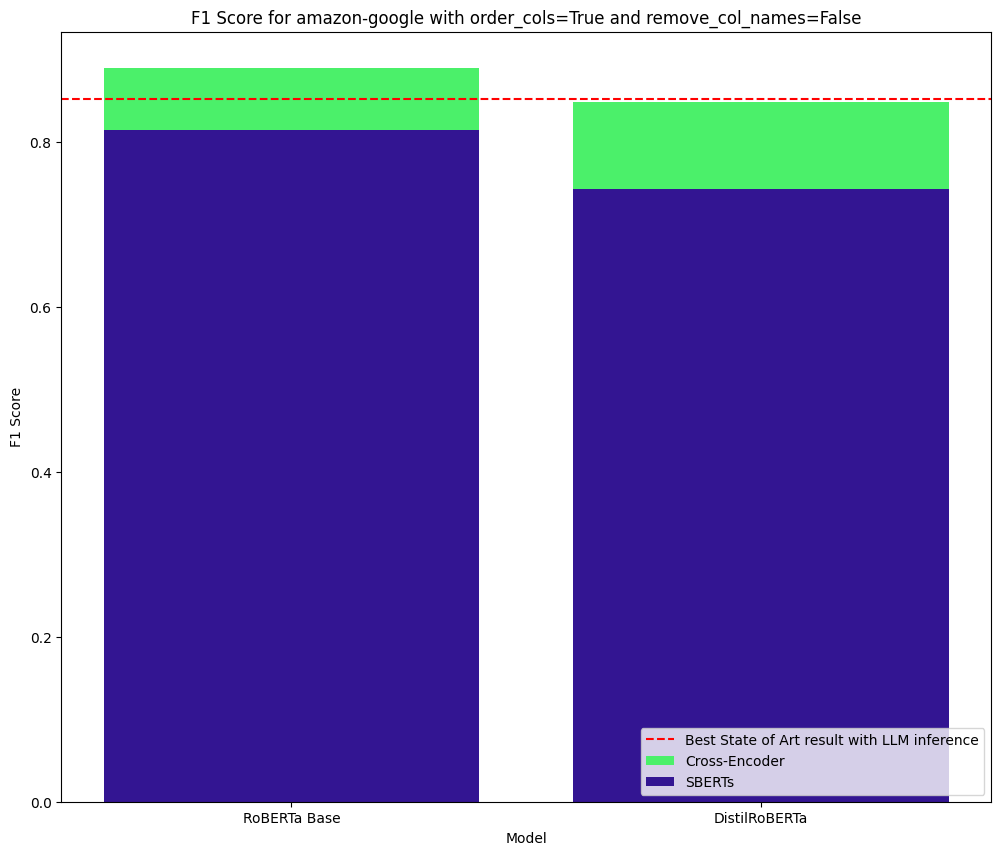

In [38]:
data_name = 'amazon-google'
order_cols = True
remove_col_names = False

f1_score_cross_roberta_base = results_dict_cross[data_name]['cross-encoder/stsb-roberta-base'][order_cols][remove_col_names]['f1']
f1_score_cross_distilbert = results_dict_cross[data_name]['cross-encoder/stsb-distilroberta-base'][order_cols][remove_col_names]['f1']

f1_score_bert_roberta_base = results_dict_bert[data_name]['roberta-base'][order_cols][remove_col_names]['f1']
f1_score_bert_distilbert = results_dict_bert[data_name]['distilroberta-base'][order_cols][remove_col_names]['f1']

plt.figure(figsize=(12, 10))
index = ['RoBERTa Base', 'DistilRoBERTa']

plt.bar(
    index,
    [f1_score_cross_roberta_base, f1_score_cross_distilbert],
    color='#4BF06A',
    label='Cross-Encoder'
)
plt.bar(
    index,
    [f1_score_bert_roberta_base, f1_score_bert_distilbert],
    color='#331592',
    label='SBERTs'
)
plt.axhline(y=0.8521, color='red', linestyle='--', label='Best State of Art result with LLM inference')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title(f'F1 Score for {data_name} with order_cols={order_cols} and remove_col_names={remove_col_names}')
plt.xticks(range(len(index)), index)
plt.legend(loc='lower right')
plt.show()